In [1]:
import Pkg
Pkg.activate("../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using DataFrames, TimeSeries, XLSX
using StatsBase
using Plots
using GLM

In [57]:
df = DataFrame(XLSX.readtable("../data/spx_daily.xlsx", "^spx_d", infer_eltypes=true))
data_source = TimeArray(df[!, [:Data, :Zamkniecie]]; timestamp = :Data)
returns_d = percentchange(data_source, :log)

7866×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1994-05-03 to 2025-08-01
┌────────────┬──────────────┐
│            │ Zamkniecie   │
├────────────┼──────────────┤
│ 1994-05-03 │   2.20738e-5 │
│ 1994-05-04 │  -0.00289583 │
│ 1994-05-05 │ -0.000752962 │
│ 1994-05-06 │  -0.00791819 │
│ 1994-05-09 │   -0.0123578 │
│ 1994-05-10 │   0.00830777 │
│ 1994-05-11 │    -0.010186 │
│ 1994-05-12 │   0.00510597 │
│     ⋮      │      ⋮       │
│ 2025-07-24 │  0.000697989 │
│ 2025-07-25 │   0.00396644 │
│ 2025-07-28 │  0.000176861 │
│ 2025-07-29 │  -0.00296381 │
│ 2025-07-30 │  -0.00125022 │
│ 2025-07-31 │   -0.0037017 │
│ 2025-08-01 │   -0.0161213 │
└────────────┴──────────────┘
            7851 rows omitted

In [76]:
y_vol = moving(std, returns_d, 252)
q_vol = moving(std, returns_d, 60)

y_vol_q = (collapse(y_vol, Dates.quarter, last))
q_vol_q = (collapse(q_vol, Dates.quarter, first))

125×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1994-07-27 to 2025-07-01
┌────────────┬────────────┐
│            │ Zamkniecie │
├────────────┼────────────┤
│ 1994-07-27 │ 0.00546957 │
│ 1994-10-03 │ 0.00525467 │
│ 1995-01-03 │ 0.00643038 │
│ 1995-04-03 │ 0.00432221 │
│ 1995-07-03 │ 0.00555471 │
│ 1995-10-02 │ 0.00443298 │
│ 1996-01-02 │ 0.00555277 │
│ 1996-04-01 │ 0.00865597 │
│     ⋮      │     ⋮      │
│ 2024-01-02 │ 0.00757181 │
│ 2024-04-01 │  0.0067796 │
│ 2024-07-01 │ 0.00647469 │
│ 2024-10-01 │  0.0104167 │
│ 2025-01-02 │ 0.00793289 │
│ 2025-04-01 │  0.0103578 │
│ 2025-07-01 │  0.0180778 │
└────────────┴────────────┘
           110 rows omitted

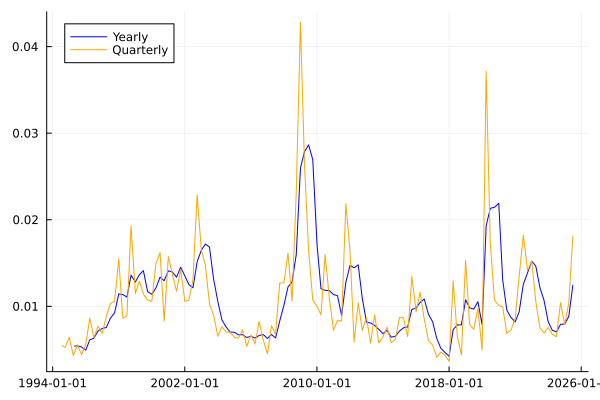

In [59]:
plot(y_vol_q, color=:blue, label="Yearly")
plot!(q_vol_q, color=:orange, label="Quarterly")

In [60]:
data_y = merge(y_vol_q, TimeSeries.lag(y_vol_q), TimeSeries.lag(y_vol_q, 2))

120×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 1995-10-02 to 2025-07-01
┌────────────┬────────────┬──────────────┬──────────────┐
│            │ Zamkniecie │ Zamkniecie_1 │ Zamkniecie_2 │
├────────────┼────────────┼──────────────┼──────────────┤
│ 1995-10-02 │ 0.00530114 │   0.00543491 │    0.0054103 │
│ 1996-01-02 │  0.0049293 │   0.00530114 │   0.00543491 │
│ 1996-04-01 │ 0.00613904 │    0.0049293 │   0.00530114 │
│ 1996-07-01 │ 0.00631097 │   0.00613904 │    0.0049293 │
│ 1996-10-01 │ 0.00714785 │   0.00631097 │   0.00613904 │
│ 1997-01-02 │ 0.00744565 │   0.00714785 │   0.00631097 │
│ 1997-04-01 │ 0.00754808 │   0.00744565 │   0.00714785 │
│ 1997-07-01 │ 0.00861991 │   0.00754808 │   0.00744565 │
│     ⋮      │     ⋮      │      ⋮       │      ⋮       │
│ 2024-01-02 │ 0.00822143 │    0.0107018 │    0.0121676 │
│ 2024-04-01 │ 0.00724247 │   0.00822143 │    0.0107018 │
│ 2024-07-01 │ 0.00703349 │   0.00724247 │   0.00822143 │
│ 2024-10-01 │ 0.00791727 │   0.00703349 │   0.0072424

In [61]:
ar_y_vol = lm(@formula(Zamkniecie ~ Zamkniecie_1), data_y)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Zamkniecie ~ 1 + Zamkniecie_1

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)   0.00147148  0.000527894   2.79    0.0062  0.000426103  0.00251685
Zamkniecie_1  0.870316    0.0443751    19.61    <1e-38  0.782441     0.958191
───────────────────────────────────────────────────────────────────────────────

In [62]:
round(r2(ar_y_vol); digits=4)

0.7652

In [63]:
res_y = residuals(ar_y_vol)

display(skewness(res_y))
display(kurtosis(res_y))

1.1322599245750298

7.783132286912775

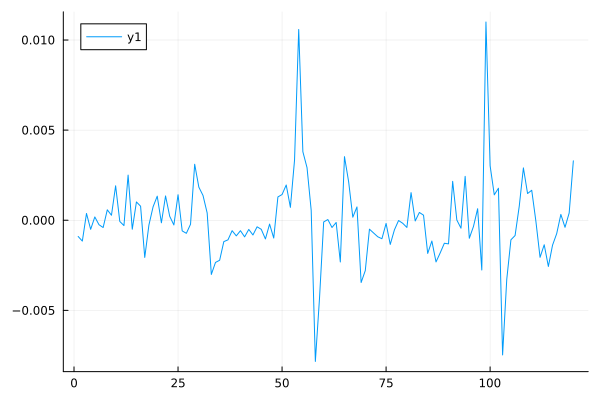

In [64]:
plot(res_y)

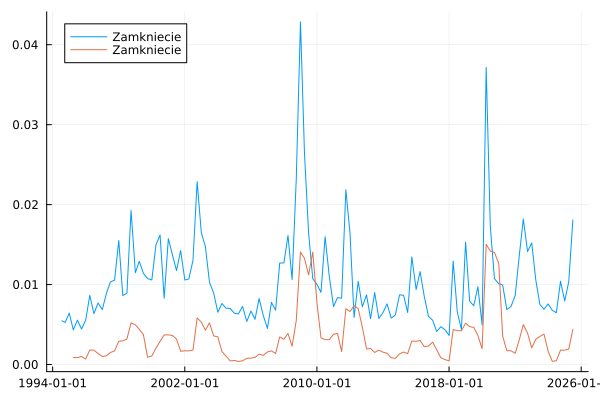

In [65]:
ma_q_vol = moving(std, q_vol_q, 4)

plot(q_vol_q)
plot!(ma_q_vol)

In [66]:
data_y

120×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 1995-10-02 to 2025-07-01
┌────────────┬────────────┬──────────────┬──────────────┐
│            │ Zamkniecie │ Zamkniecie_1 │ Zamkniecie_2 │
├────────────┼────────────┼──────────────┼──────────────┤
│ 1995-10-02 │ 0.00530114 │   0.00543491 │    0.0054103 │
│ 1996-01-02 │  0.0049293 │   0.00530114 │   0.00543491 │
│ 1996-04-01 │ 0.00613904 │    0.0049293 │   0.00530114 │
│ 1996-07-01 │ 0.00631097 │   0.00613904 │    0.0049293 │
│ 1996-10-01 │ 0.00714785 │   0.00631097 │   0.00613904 │
│ 1997-01-02 │ 0.00744565 │   0.00714785 │   0.00631097 │
│ 1997-04-01 │ 0.00754808 │   0.00744565 │   0.00714785 │
│ 1997-07-01 │ 0.00861991 │   0.00754808 │   0.00744565 │
│     ⋮      │     ⋮      │      ⋮       │      ⋮       │
│ 2024-01-02 │ 0.00822143 │    0.0107018 │    0.0121676 │
│ 2024-04-01 │ 0.00724247 │   0.00822143 │    0.0107018 │
│ 2024-07-01 │ 0.00703349 │   0.00724247 │   0.00822143 │
│ 2024-10-01 │ 0.00791727 │   0.00703349 │   0.0072424

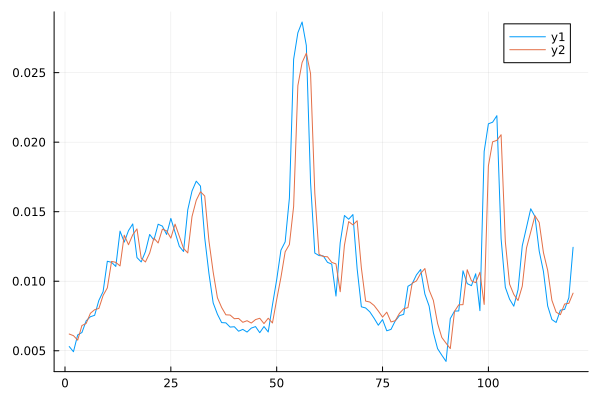

In [67]:
predicted = predict(ar_y_vol, data_y[:Zamkniecie_1])

plot(values(data_y[:Zamkniecie]))
plot!(predicted)

In [75]:
df = DataFrame(XLSX.readtable("../data/usa_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, first)

freq = 4
cpi = percentchange(data_source[:CPI], :log) 
real_t_bill = log1p.(data_source[:T_Bill])./freq .- cpi
div_growth = percentchange(data_source[:Dividend], :log) 
returns = percentchange(data_source[:Total_Stock], :log)

#data = merge(returns, div_growth, real_t_bill, y_vol_q)

291×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1952-01-01 to 2024-07-01
┌────────────┬─────────────┐
│            │ Total_Stock │
├────────────┼─────────────┤
│ 1952-01-01 │   0.0202499 │
│ 1952-04-01 │  -0.0192735 │
│ 1952-07-01 │   0.0996562 │
│ 1952-10-01 │  -0.0205798 │
│ 1953-01-01 │   0.0862211 │
│ 1953-04-01 │  -0.0547653 │
│ 1953-07-01 │   0.0197158 │
│ 1953-10-01 │  0.00657604 │
│     ⋮      │      ⋮      │
│ 2023-01-01 │   0.0556498 │
│ 2023-04-01 │   0.0266851 │
│ 2023-07-01 │   0.0996552 │
│ 2023-10-01 │  -0.0859001 │
│ 2024-01-01 │    0.148025 │
│ 2024-04-01 │   0.0418999 │
│ 2024-07-01 │   0.0954622 │
└────────────┴─────────────┘
            276 rows omitted